In [13]:
import numpy as np
import sgtpy as vr
import epcsaftpy as pc

comp2_name = 'n-butane'
path_pc = './parameters/gross2001.json'
path_exp = './data_exp/VLEP_H2+C4.txt'
letter_figure = "D"
Pf = 800e5 # Pa
skip_calculation_pc = False  # True if the calculation is already done

# PC-SAFT definition

In [14]:
H2 = pc.component('hydrogen', pure_path = './parameters/hydrogen.json')
comp2 =  pc.component(comp2_name, pure_path = path_pc)
mix = H2 + comp2
saft_pc = pc.pcsaft(mix)
mix.printParameters()

print('\n Critical point calculation 1 success: ',saft_pc.pure_eos[0].critical)
if saft_pc.pure_eos[0].critical:
    print(f' * Critical temperature : {round(saft_pc.pure_eos[0].Tc,4)} K')
    print(f' * Critical pressure    : {round(saft_pc.pure_eos[0].Pc * 1e-5,2)} bar')
    print(f' * Critical density     : {round(saft_pc.pure_eos[0].rhoc * 1e-3,4)} kmol/m^3')

print('\n Critical point calculation 2 success: ',saft_pc.pure_eos[1].critical)
if saft_pc.pure_eos[1].critical:
    print(f' * Critical temperature : {round(saft_pc.pure_eos[1].Tc,4)} K')
    print(f' * Critical pressure    : {round(saft_pc.pure_eos[1].Pc * 1e-5,2)} bar')
    print(f' * Critical density     : {round(saft_pc.pure_eos[1].rhoc * 1e-3,4)} kmol/m^3')

component,Mw,$ms$,$\sigma$,$\epsilon / k_B $,reference
hydrogen,2.016,1.0000,2.9860,19.2775,parameters/hydrogen.json
n-butane,58.123,2.3316,3.7086,222.8800,parameters/gross2001.json



 Critical point calculation 1 success:  True
 * Critical temperature : 24.5932 K
 * Critical pressure    : 11.46 bar
 * Critical density     : 17.6131 kmol/m^3

 Critical point calculation 2 success:  True
 * Critical temperature : 432.5037 K
 * Critical pressure    : 42.19 bar
 * Critical density     : 3.7733 kmol/m^3


In [15]:
# Read the experimental data from a .txt file
T_exp, x1_exp, P_exp = np.loadtxt(path_exp, unpack=True)
T_list = np.unique(T_exp)
n_T = len(T_list)

# Solving for PC-SAFT

In [16]:
# Solving the bubble point pressure for each temperature
saft = saft_pc
x10 = 1e-6
x1f = 0.9
n = 301
x1j = np.linspace(x10, x1f, n)

y1 = []
x1 = []
P = []


yzero = 1e-3
y_guess = np.array([1. - yzero, yzero])
v0_guess = [None, None]
Xass0_guess = [None, None]


for i in range(n_T):
    Ti = T_list[i]
    y0 = y_guess.copy()
    P0 , vl, vv = saft.pure_eos[1].psat(Ti)
    v0 = [vl, vv]
    Xass0 = Xass0_guess

    P_T = [P0 * 1e-5]
    x1_T = [0]
    y1_T = [0]

    # Iterating over the liquid mole fraction
    for j in range(n):
        x = np.array([x1j[j], 1 - x1j[j]])
        out = vr.equilibrium.bubblePy(y0, P0, x, Ti, saft, good_initial=False,
                    v0 = v0, Xass0 = Xass0, full_output=True)
        if out.error < 1e-8:
            y0 = out.Y
            x0 = out.X
            P0 = out.P
            v0 = [out.v1, out.v2]
            Xass0 = [out.Xassl, out.Xassv]
            P_T.append(P0 * 1e-5)
            x1_T.append(x[0])
            y1_T.append(y0[0])
        else:
            break
        if j == 0:
            y_guess = y0.copy()
        if P0 > Pf:
            break

    # Iterating over the pressure
    k = 0
    dP = 5.*1e5
    P0 -= dP
    tol = 1e-6
    nacc = 5
    K_tol = 1e-8
    while P0 < Pf and k < 1000:
        k += 1
        P0 += dP
        z = (x0 + y0)/2
        out_flash = vr.equilibrium.flash(x0, y0, 'VL', z, Ti, P0, saft, v0 = v0, Xass0 = Xass0, full_output=True, nacc = nacc, K_tol=K_tol)

        if out_flash.error < tol:
            y0 = out_flash.Y
            x0 = out_flash.X
            v0 = [out_flash.v1, out_flash.v2]
            Xass0 = [out_flash.Xass1, out_flash.Xass2]
            P_T.append(P0 * 1e-5)
            x1_T.append(x0[0])
            y1_T.append(y0[0])
            if abs(v0[0] - v0[1])/v0[1] < 1e-3 and abs(x0[0] - y0[0]) < 1e-2:
                break
        else:
            tol *= 2
            tol = min(1e-5, tol)
            K_tol /= 2
            K_tol = max(1e-10, K_tol)
            nacc += 1
            naac = min(15, nacc)
            dP *= 0.5
            P0 -= dP
            dP = max(dP, 1e4)
    P.append(P_T)
    x1.append(x1_T)
    y1.append(y1_T)

                
out_pc = {'x1': x1, 'y1': y1, 'P': P}

c:\Users\nfgaj\anaconda3\Lib\site-packages\sgtpy\equilibrium\bubble.py:37: RuntimeWarning: overflow encountered in exp
  K = np.exp(lnK)
c:\Users\nfgaj\anaconda3\Lib\site-packages\sgtpy\equilibrium\bubble.py:56: RuntimeWarning: invalid value encountered in divide
  Y = Y_calc/Y_calc.sum()
c:\Users\nfgaj\anaconda3\Lib\site-packages\sgtpy\equilibrium\bubble.py:56: RuntimeWarning: divide by zero encountered in divide
  Y = Y_calc/Y_calc.sum()
c:\Users\nfgaj\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\nfgaj\anaconda3\Lib\site-packages\epcsaftpy\pcsaft_mixtures\ares.py:21: RuntimeWarning: invalid value encountered in matmul
  dxhi_dxhi00 = np.matmul(xmi, di03)
c:\Users\nfgaj\anaconda3\Lib\site-packages\epcsaftpy\pcsaft_mixtures\chain\achain.py:36: RuntimeWarning: invalid value encountered in multiply
  return - lngHS@(x * (ms - 1.))
c:\Users\nfgaj\anaconda3\L

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

# Plotting

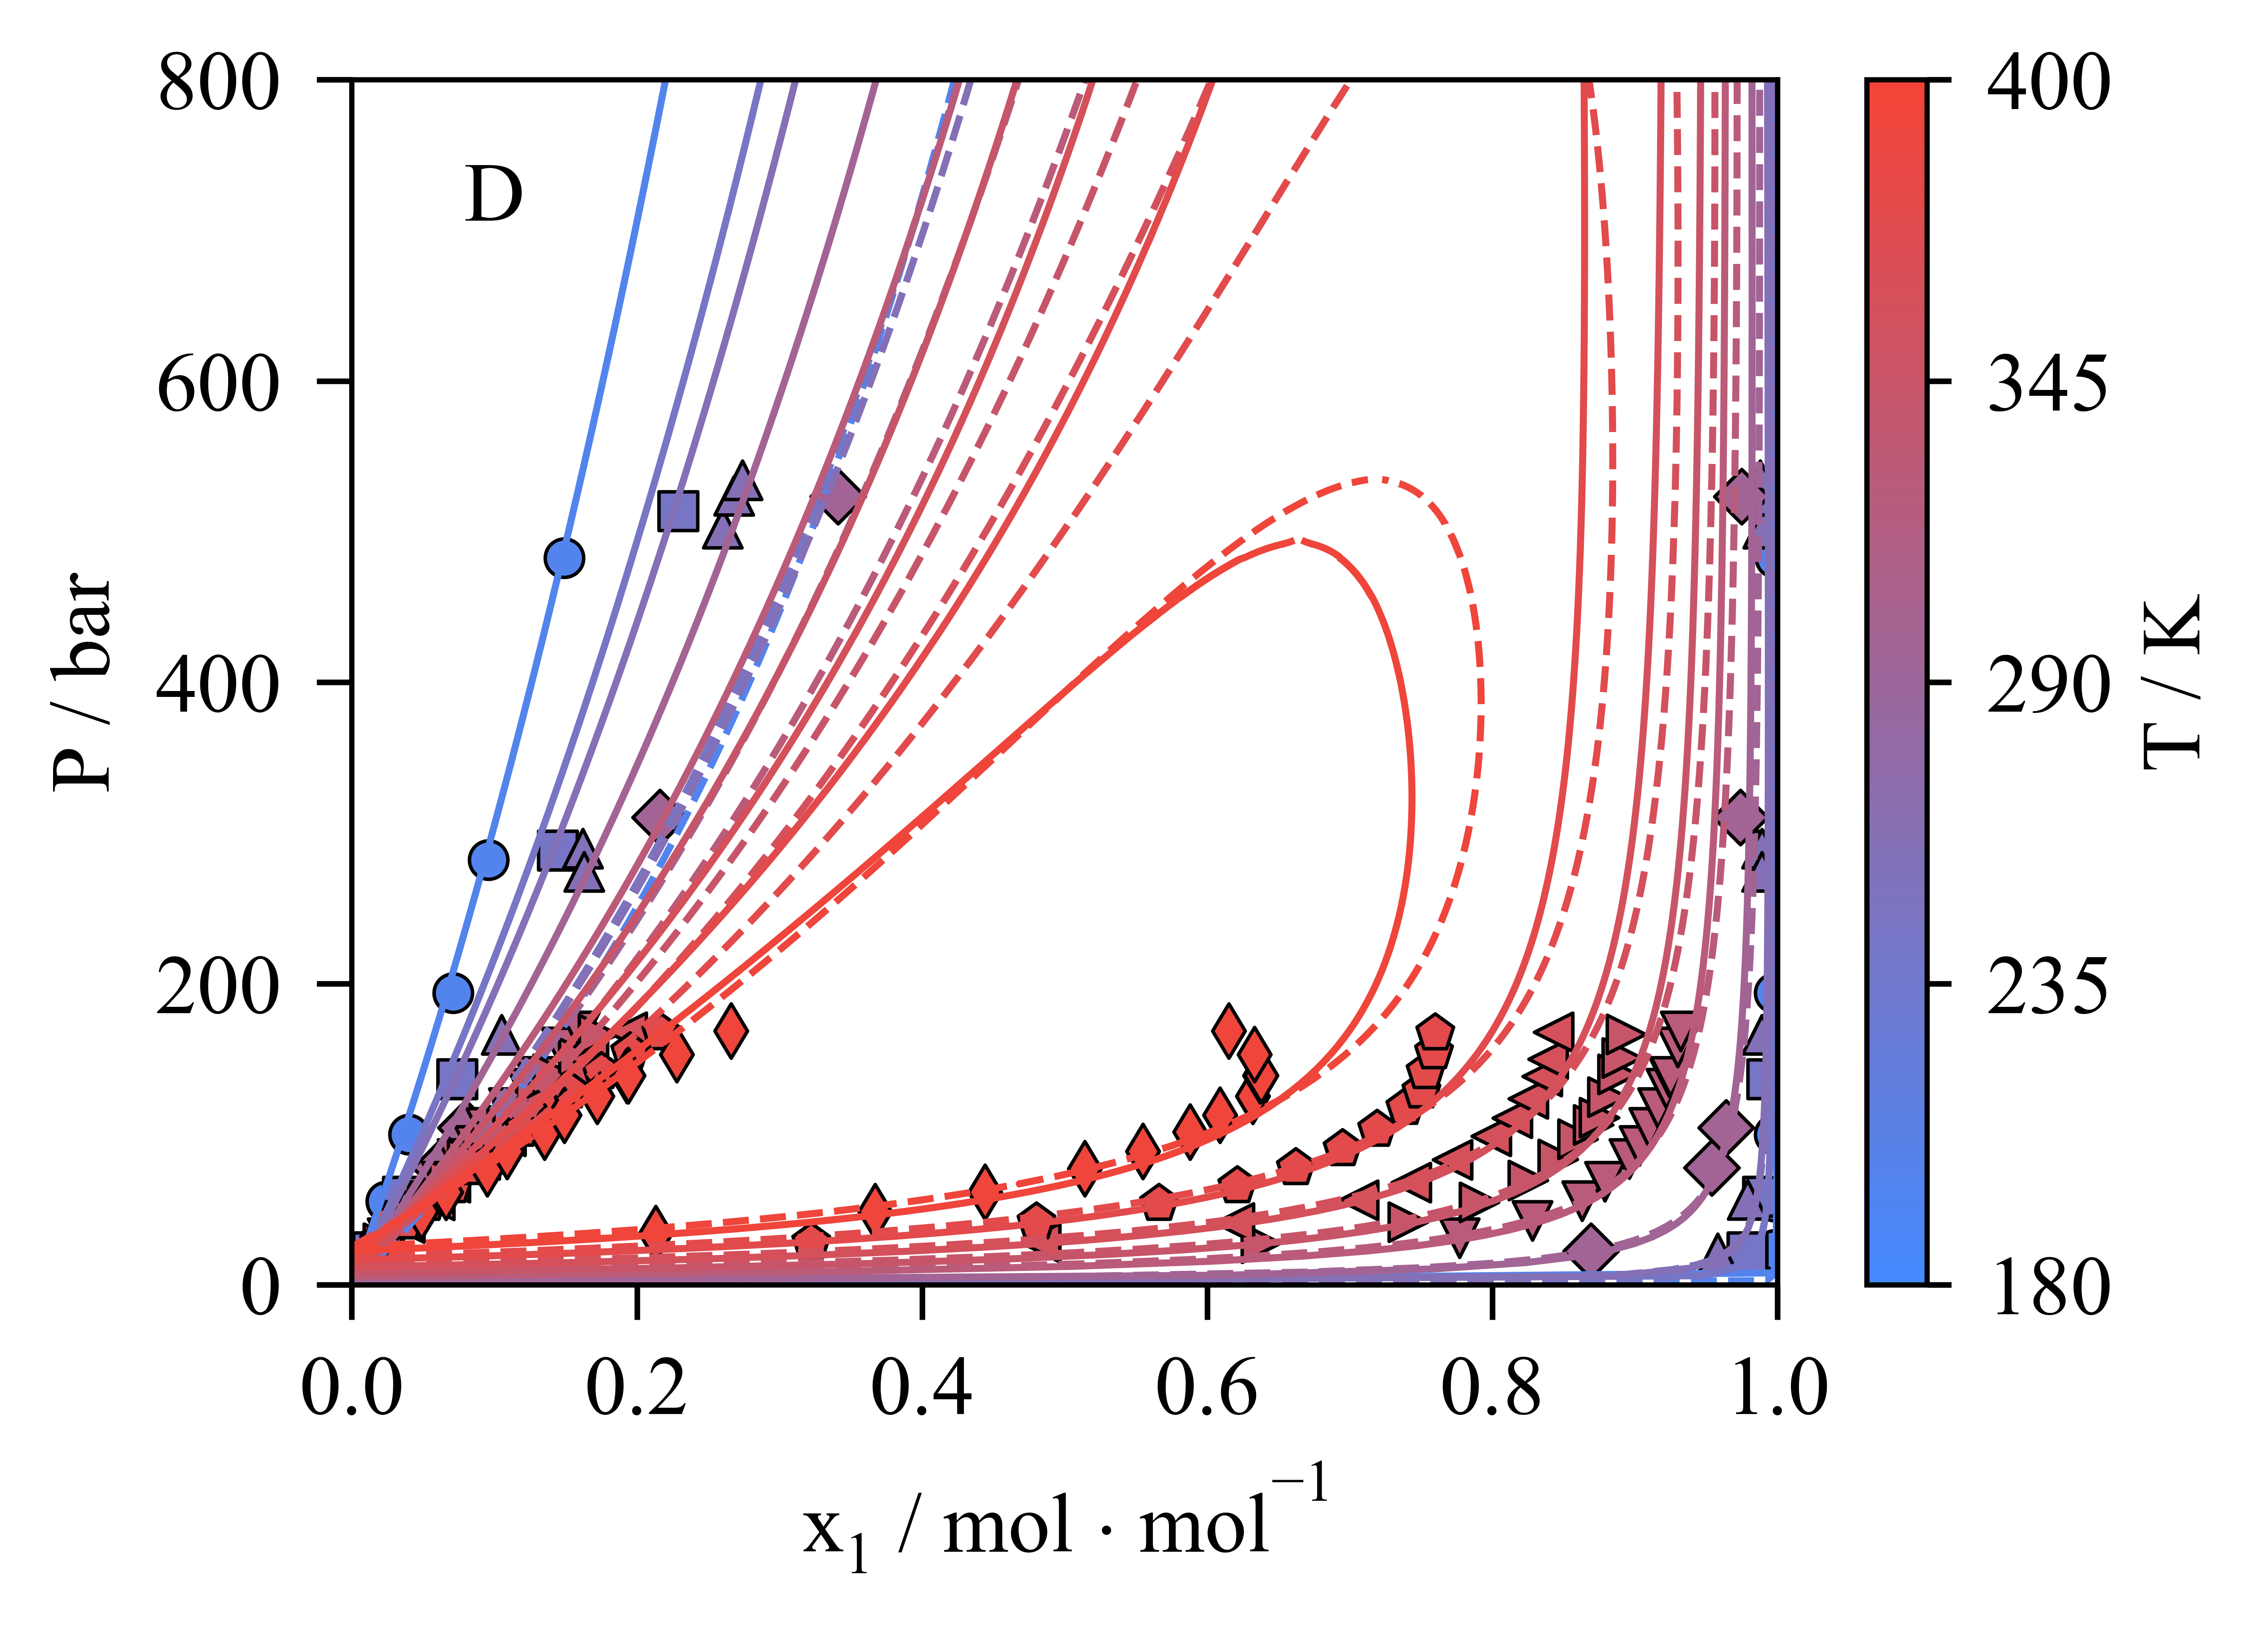

In [7]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import matplotlib.colors as mcolors

def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]
 
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Times New Roman'
matplotlib.rcParams['mathtext.it'] = 'Times New Roman'
matplotlib.rcParams['mathtext.bf'] = 'Times New Roman'
matplotlib.rcParams['xtick.major.pad']='5'
matplotlib.rcParams['ytick.major.pad']='5'
matplotlib.rcParams['axes.linewidth'] = 0.75
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams['savefig.dpi'] = 1200

font = {'weight' : 'normal',
        'size'   : 12,
        'family' : "Times New Roman"}
plt.rc('font', **font)
plt.rc('axes', titlesize=font["size"])


color1 = '#448AFF'
color2 = "#F44336"

Tmin = round(min(T_list)/10/2 - 0.5,0) * 10 * 2
Tmax = round(max(T_list)/10/2 + 0.5,0) * 10 * 2

n = int(Tmax - Tmin + 1)
colors = get_color_gradient(color1, color2, n)


cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors)
data = np.random.rand(10, 10)
fig, ax = plt.subplots()
im = ax.imshow(data, cmap=cmap, vmin=Tmin, vmax=Tmax)
cb = plt.colorbar(im, ax=ax)
cb.ax.tick_params(colors='black', labelsize=12)
plt.close()

 
symbols = ['o', 's', '^', 'D', 'v', '>', '<', 'p', 'd']

fig, ax = plt.subplots( figsize=(3.93701 + 0.5, 3.1496), dpi=1200)


for i in range(n_T):
    color = colors[int(T_list[i] - Tmin)]
    ax.plot(out_vr["x1"][i], out_vr["P"][i], color = color, linewidth = 1., linestyle = '--')
    ax.plot(out_vr["y1"][i], out_vr["P"][i], color = color, linewidth = 1., linestyle = '--')
    ax.plot(out_pc["x1"][i], out_pc["P"][i], color = color, linewidth = 1.)
    ax.plot(out_pc["y1"][i], out_pc["P"][i], color = color, linewidth = 1.)
    ax.scatter(x1_exp[T_exp == T_list[i]], P_exp[T_exp == T_list[i]], 
               color = color, marker = symbols[i], linewidth=0.5, edgecolor='k', label = f'$T = {T_list[i]:.0f}$ K', s = 30)
    

ax.text(0.1, 0.9, letter_figure, horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize = 12)    
ax.set_xlim(0, 1)
ax.set_ylim(0, Pf/1e5)
ax.set_xlabel('$x_1$ / mol $\cdot$ mol$^{-1}$')
ax.set_ylabel('$P$ / bar')
ax.xaxis.set_ticks(np.linspace(0, 1, 6))
ax.yaxis.set_ticks(np.linspace(0, Pf/1e5, 5))
ax.tick_params(which='major', length=5)
ax.tick_params(which='minor', length=3)
# every 20 K colorbar
cb = plt.colorbar(im, ax=ax, ticks=np.linspace(Tmin, Tmax, 5))
cb.ax.tick_params(colors='black', labelsize=12)
cb.set_label(r'$T$ / K', fontsize=12)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig('figures/VLEP_H2+' + comp2_name + '.pdf')
plt.show()

# Exporting

In [8]:
# Exporting the results for each temperature in different .txt file x, y, P

for i in range(n_T):
    np.savetxt(f'results/VLEP_H2+' + comp2_name + '_T_'+ str(T_list[i]) + '_vrmie.txt', np.c_[out_vr["x1"][i], out_vr["y1"][i], out_vr["P"][i]], 
               header = f'x, y, P', 
               comments = '#')
    
for i in range(n_T):
    np.savetxt(f'results/VLEP_H2+' + comp2_name + '_T_'+ str(T_list[i]) + '_pcsaft.txt', np.c_[out_pc["x1"][i], out_pc["y1"][i], out_pc["P"][i]], 
               header = f'x, y, P', 
               comments = '#')

# AAD

In [9]:
# Error calculation
from scipy.interpolate import CubicSpline
def AAD_calculation(out):
    print('---------------------------------')
    x1, y1, P = out['x1'], out['y1'], out['P']
    dy, dP, ndata = 0., 0., 0.
    for i in range(n_T):
        x1_exp_T, P_exp_T = x1_exp[T_exp==T_list[i]], P_exp[T_exp==T_list[i]]
        x1_cal_T, y1_cal_T, P_cal_T = x1[i], y1[i], P[i]
        dy_T, dP_T, ndata_T = 0., 0., len(x1_exp_T)
        ndata += ndata_T

        for j in range(ndata_T):
            P_diff = abs(P_exp_T[j] - P_cal_T)
            ndx_mid = np.argmin(P_diff)
            ndx_min = max(0, ndx_mid - 1)
            ndx_max = min(len(P_cal_T), ndx_mid + 1)
            cs_x1 = CubicSpline(P_cal_T[ndx_min:ndx_max], x1_cal_T[ndx_min:ndx_max])
            cs_y1 = CubicSpline(P_cal_T[ndx_min:ndx_max], y1_cal_T[ndx_min:ndx_max])
            x1_cal, y1_cal = cs_x1(P_exp_T[j]), cs_y1(P_exp_T[j])
            dy_T += min( abs(x1_cal - x1_exp_T[j]), abs(y1_cal - x1_exp_T[j]))
        dy += dy_T
        dy_T *= 100./ndata_T

        for j in range(ndata_T):
            x1_diff = abs(x1_exp_T[j] - x1_cal_T)
            y1_diff = abs(x1_exp_T[j] - y1_cal_T)
            ndx_mid = np.argmin(y1_diff)
            ndx_min = max(0, ndx_mid - 1)
            ndx_max = min(len(y1_cal_T), ndx_mid + 1)
            if ndx_min == ndx_max-1:
                P_cal_y = P_cal_T[ndx_min]
            else:
                if y1_cal_T[ndx_min:ndx_max][0] > y1_cal_T[ndx_min:ndx_max][-1]:
                    cs_P = CubicSpline(np.flip(y1_cal_T[ndx_min:ndx_max]), np.flip(P_cal_T[ndx_min:ndx_max]))
                else:
                    cs_P = CubicSpline(y1_cal_T[ndx_min:ndx_max], P_cal_T[ndx_min:ndx_max])
                P_cal_y = cs_P(x1_exp_T[j])
            ndx_mid = np.argmin(x1_diff)
            ndx_min = max(0, ndx_mid - 1)
            ndx_max = min(len(x1_cal_T), ndx_mid + 1)
            cs_P  = CubicSpline(x1_cal_T[ndx_min:ndx_max], P_cal_T[ndx_min:ndx_max])
            P_cal_x = cs_P(x1_exp_T[j])
            if x1_exp_T[j] < x1_exp_T[j-1]:
                P_cal = max(P_cal_x, P_cal_y)
            else:
                if abs(P_cal_x - P_exp_T[j]) < abs(P_cal_y - P_exp_T[j]):
                    P_cal = P_cal_x
                else:
                    P_cal = P_cal_y
            #print(x1_exp_T[j], P_exp_T[j], P_cal)
            if P_cal > 300:
                continue
            else:
                dP_T += abs(P_exp_T[j] - P_cal)/P_exp_T[j]
        dP += dP_T
        dP_T *= 100./ndata_T

        print(f'T = {T_list[i]} K\tdP = {dP_T:.2f} %\tdy = {dy_T:.2f} %')
    dP *= 100./ndata
    dy *= 100./ndata
    print(f'AAD in pressure: {dP:.2f} %')
    print(f'AAD in mole fraction: {dy:.2f} %')
    print(f'Number of data points: {ndata:.0f}')
    print('---------------------------------')

print('SAFT-VR Mie')
AAD_calculation(out_vr)
print('PC-SAFT')
AAD_calculation(out_pc)

SAFT-VR Mie
---------------------------------
T = 199.82 K	dP = 55.88 %	dy = 4.08 %
T = 244.26 K	dP = 32.63 %	dy = 2.41 %
T = 260.93 K	dP = 32.86 %	dy = 2.41 %
T = 297.04 K	dP = 19.86 %	dy = 1.01 %
T = 327.6 K	dP = 9.65 %	dy = 0.72 %
T = 344.18 K	dP = 6.48 %	dy = 0.73 %
T = 360.88 K	dP = 5.74 %	dy = 0.98 %
T = 377.47 K	dP = 6.59 %	dy = 1.44 %
T = 394.17 K	dP = 19.98 %	dy = 2.07 %
AAD in pressure: 17.21 %
AAD in mole fraction: 1.57 %
Number of data points: 168
---------------------------------
PC-SAFT
---------------------------------
T = 199.82 K	dP = 43.95 %	dy = 0.25 %
T = 244.26 K	dP = 34.93 %	dy = 0.72 %
T = 260.93 K	dP = 31.31 %	dy = 1.49 %
T = 297.04 K	dP = 20.96 %	dy = 1.52 %
T = 327.6 K	dP = 15.01 %	dy = 1.15 %
T = 344.18 K	dP = 13.15 %	dy = 1.23 %
T = 360.88 K	dP = 11.16 %	dy = 1.28 %
T = 377.47 K	dP = 9.84 %	dy = 1.49 %
T = 394.17 K	dP = 24.25 %	dy = 2.39 %
AAD in pressure: 19.98 %
AAD in mole fraction: 1.37 %
Number of data points: 168
---------------------------------
